<a href="https://colab.research.google.com/github/julie-dfx/causal-decision-analytics/blob/main/00_reboot_08_power_and_multiple_testings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical power

## Definition
Power = P(reject Ho | H1 is true)
It represents the probability of correctly detecting a true effect
It it the complement of the type II error: Power = 1 - beta



## Power as overlap of distributions
visualise simlulated null vs alternative distributions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(26)

n = 1000
baseline = 0.60
effect = 0.02
alpha = 0.05

diffs_null = []
diffs_alt = []

for _ in range(4000):
    c = np.random.binomial(1, baseline, n)
    t = np.random.binomial(1, baseline + effect, n)

    diffs_null.append(c.mean() - np.random.binomial(1, baseline, n).mean())
    diffs_alt.append(t.mean() - c.mean())


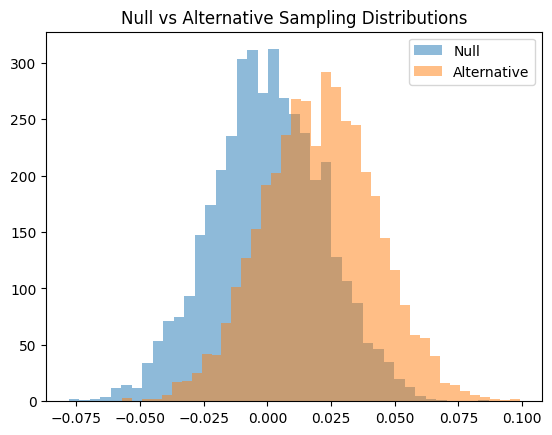

In [2]:
#plot both
plt.figure()
plt.hist(diffs_null, bins=40, alpha=0.5, label="Null")
plt.hist(diffs_alt, bins=40, alpha=0.5, label="Alternative")
plt.legend()
plt.title("Null vs Alternative Sampling Distributions")
plt.show()

#this overlap region visually represents:
## Type I area
## Type II area
#Power increases when distributions are separate

## Analytical Power using statsmodels



In [3]:
from statsmodels.stats.power import TTestIndPower

analysis = TTestIndPower()

# Convert proportion diff to standardized effect size
pooled_sd = np.sqrt(baseline * (1 - baseline))
effect_size = effect / pooled_sd

power = analysis.power(
    effect_size=effect_size,
    nobs1=n,
    alpha=alpha,
    alternative='two-sided'
)

power
#close to what we had before

np.float64(0.14946404928989993)

## Power curve
now we compute power for different sample sizes


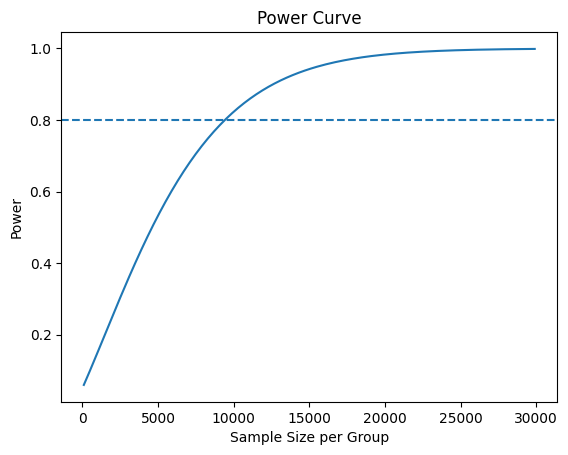

In [4]:
sample_sizes = np.arange(100, 30000, 200)
powers = []

for size in sample_sizes:
  p = analysis.power(
      effect_size=effect_size,
      nobs1=size,
      alpha=alpha,
      alternative='two-sided'
  )
  powers.append(p)

plt.figure()
plt.plot(sample_sizes, powers)
plt.axhline(0.8, linestyle="--")
plt.xlabel("Sample Size per Group")
plt.ylabel("Power")
plt.title("Power Curve")
plt.show()

#power grows non linearly
#it flattens at high n
#there is diminishing return

## Compute MDE for fixed n



In [5]:
def compute_mde(n, power=0.8, alpha= 0.05):
  return analysis.solve_power(
      effect_size=None, # Set to None to solve for MDE (effect_size)
      nobs1=n,
      power=power,
      alpha=alpha,
      alternative='two-sided'
  )
mde_std = compute_mde(1500)
mde_absolute = mde_std * pooled_sd
mde_absolute

# With 1500 per group, the smallest reliably detectable uplift is X --> this reframes the experiment

np.float64(0.05013227964634916)

## Interpretation and Decision

 If the compensation program realistically increases retention by 0.5 pp b¨t the MDE is 1.8 pp, we are statistically blind

 The correct conclusion is then "we cannot detect effects of this magnitude with this design"

## Key Power Insights
- Power reflects the separation between null and alrternative distributions
- Small effects require disproportionately large samples
- Underpowered experiments frequently yield non-significant results, even when real effect exists
- MDE reframes experiments from estimation to detectability

# Minimum Detectable Effect - MDE

## Definition
MDE is the smallest true effect size that a study can detect with specified power and significance level
- MDE = f(n, alpha, power, sigma)
- where n = sample size, alpha = significance htreshold, power = desired detction probability, sigma = variability

In [7]:
#calculate MDE
from statsmodels.stats.power import TTestIndPower
import numpy as np

analysis = TTestIndPower()

baseline = 0.60
pooled_sd = np.sqrt(baseline * (1 - baseline))

n = 1500

mde_std = analysis.solve_power(
    effect_size=None,
    nobs1=n,
    power=0.8,
    alpha=0.05,
    alternative='two-sided'
)

mde_absolute = mde_std * pooled_sd

mde_absolute

#with 1500 per group, I cannot reliably detect effects smaller than 0.05

np.float64(0.05013227964634916)

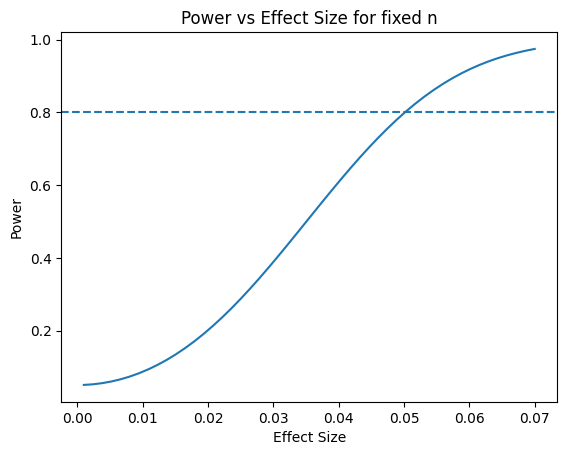

In [11]:
#visualise the detectability region
#plot power vs effect size for fixed n

alpha = 0.05
effect_sizes = np.linspace(0.001, 0.07, 50)
powers = []

for eff in effect_sizes:
  std_eff = eff / pooled_sd
  p = analysis.power(
      effect_size=std_eff,
      nobs1=n,
      alpha=alpha,
      alternative='two-sided'
  )
  powers.append(p)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(effect_sizes, powers)
plt.axhline(0.8, linestyle="--")
plt.xlabel("Effect Size")
plt.ylabel("Power")
plt.title("Power vs Effect Size for fixed n")
plt.show()

#MDE is where power curve crosses 0.8

In [13]:
#invert the question (required sample size)
# we care about detecting reliably a 1pp uplift

target_effect = 0.01
std_eff = target_effect /pooled_sd

required_n = analysis.solve_power(
    effect_size=std_eff,
    power=0.8,
    alpha=0.05,
    alternative='two-sided'
)

required_n

#37000 much larger than 1500

37675.490833730386

## MDE Insights
- MDE depends on sample size, variability and chosen power
- Small effects require large experiments
- Non-significant results in underpowered experiments are inconclusive
- Design determines detectability limits